# SIMODS 2 Figures
https://grouplens.org/datasets/movielens/

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np

In [3]:
import sys
import gc

sys.path.append("/home/ubuntu/rankability_toolbox")

In [4]:
import pandas as pd
import numpy as np
import dill

In [5]:
import pyrankability

## Movie Lens Data

In [6]:
import joblib
loaded = joblib.load("movielens-preprocess-2.joblib.z")

In [7]:
def get_P_info(info):
    P_info = {}
    for genre in info.keys():
        print(genre)
        if "k" in info[genre]:
            data = info[genre]
            n = data["D"].shape[0]
            D = data["D"]
            k = data["k"]
            details = data["details"]
            P,P_info_genre = pyrankability.hillside.find_P_from_x(D,k,details,lower_cut=1e-3,upper_cut=1-1e-3)
            P_info[genre] = P_info_genre
    return P_info

In [8]:
loaded["genre_info"]["Mystery"]['k']

86918

In [9]:
genre_P_info = get_P_info(loaded["genre_info"])

Adventure
Animation
Children
Comedy
Crime
Drama
Fantasy
Film-Noir
Horror
IMAX
Musical
Mystery
Romance
Sci-Fi
Thriller
War
Western


In [12]:
plot_df = pd.DataFrame(columns=["Genre","# items","Normalized k"])
for key in loaded["genre_info"].keys():
    if "k" in loaded["genre_info"][key]:
        k = loaded["genre_info"][key]["k"]
        D = loaded["genre_info"][key]["D"]
        n = D.shape[0]
        norm_k = k/(n**3-n**2)
        plot_df = plot_df.append(pd.Series([key,D.shape[0],norm_k],index=plot_df.columns),ignore_index=True)

In [13]:
plot_df

,Genre,# items,Normalized k
0,Adventure,292,0.171089
1,Animation,78,0.192209
2,Children,101,0.193923
3,Crime,178,0.175585
4,Fantasy,135,0.189940
5,Film-Noir,7,0.214286
6,Horror,66,0.146959
7,IMAX,49,0.255493
8,Musical,42,0.260080
9,Mystery,82,0.159587


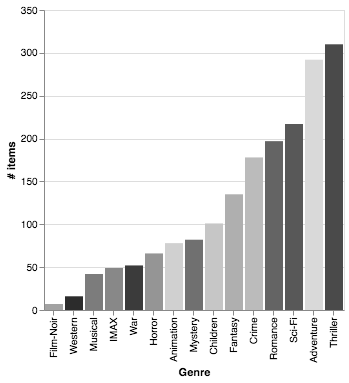

In [14]:
import altair as alt

alt.Chart(plot_df).mark_bar().encode(y="# items",x=alt.X('Genre',
                                                            sort = alt.EncodingSortField(
                                                            field="# items",
                                                            order="ascending")),
                                    color=alt.Color("Genre",scale=alt.Scale(scheme='greys'),legend=None))

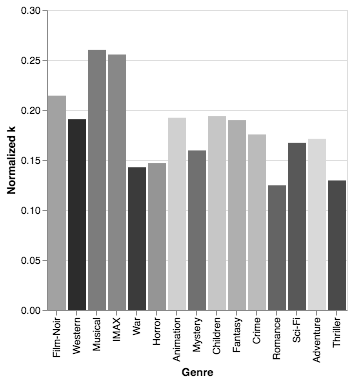

In [15]:

alt.Chart(plot_df).mark_bar().encode(y="Normalized k",x=alt.X('Genre',
                                                            sort = alt.EncodingSortField(
                                                            field="# items",
                                                            order="ascending")),
                                    color=alt.Color("Genre",scale=alt.Scale(scheme='greys'),legend=None))

In [16]:
alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

Fantasy
Musical


/data/env/lib/python3.6/site-packages/pandas/core/frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


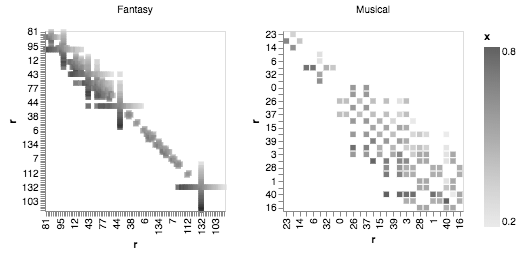

In [17]:
import altair as alt
all_df = pd.DataFrame(columns=["i","j","x","Genre","oi","oj"])
for genre in ["Fantasy","Musical"]:#genre_P_info.keys():
    print(genre)
    x = pd.DataFrame(genre_P_info[genre]['Xstar'])
    df = x.stack().reset_index()
    df.columns=["i","j","x"]
    df["oi"] = df["i"].copy()
    df["oj"] = df["j"].copy()
    df["i"] = genre_P_info[genre]['ixs'][df["i"]]
    df["j"] = genre_P_info[genre]['ixs'][df["j"]]
    df["Genre"] = genre
    all_df = all_df.append(df)

all_df = all_df.loc[(all_df.x != 0) & (all_df.x != 1)]
alt.Chart(all_df).mark_square().encode(
    x=alt.X(
        'i:N',
        axis=alt.Axis(labelOverlap="parity"),
        title="r",
        sort=alt.EncodingSortField(field="oi",order="ascending") # The order to sort in
    ),
    y=alt.Y(
        'j:N',
        axis=alt.Axis(labelOverlap="parity"),
        title="r",
        sort=alt.EncodingSortField(field="oj",order="ascending") # The order to sort in
    ),
    color=alt.Color("x",scale=alt.Scale(scheme='greys'))
).properties(
    width=180,
    height=180
).facet(
    column=alt.Column("Genre:N", title=None)
).resolve_scale(x='independent',y='independent')

Adventure
Animation
Children
Crime
Fantasy
Film-Noir
Horror
IMAX
Musical
Mystery
Romance
Sci-Fi
Thriller
War
Western


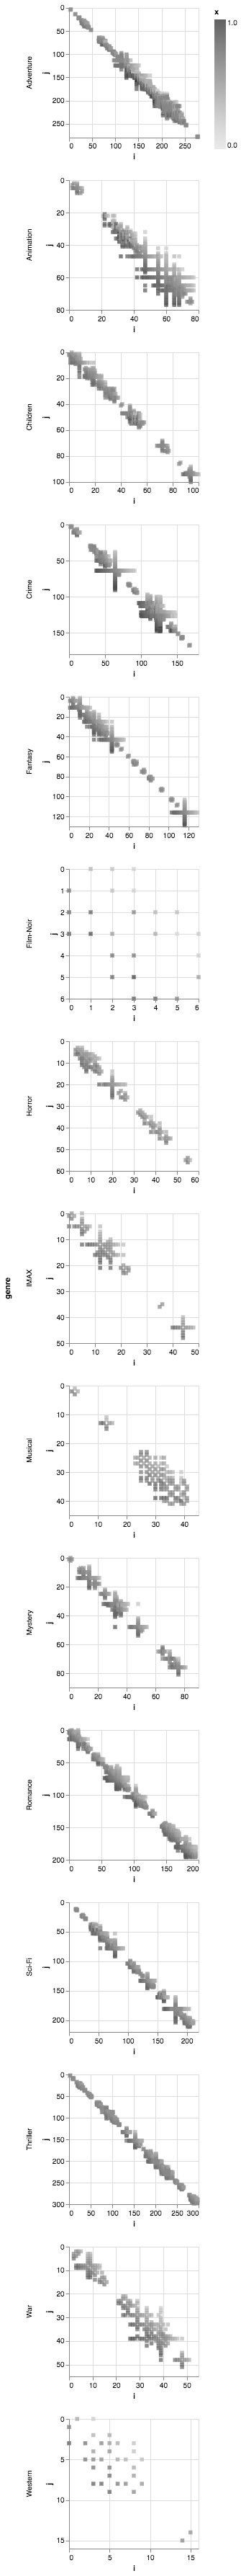

In [48]:
import altair as alt
all_df = pd.DataFrame(columns=["i","j","x","genre"])
for genre in genre_P_info.keys():
    print(genre)
    x = pd.DataFrame(genre_P_info[genre]['Xstar'])
    df = x.stack().reset_index()
    df.columns=["i","j","x"]
    df["genre"] = genre
    all_df = all_df.append(df)

all_df = all_df.loc[(all_df.x != 0) & (all_df.x != 1)]
alt.Chart(all_df).mark_square().encode(
    x=alt.X(
        'i',
        sort="ascending"  # The order to sort in
    ),
    y=alt.Y(
        'j',
        sort="descending"  # The order to sort in
    ),
    color=alt.Color("x",scale=alt.Scale(scheme='greys'))
).properties(
    width=180,
    height=180
).facet(
    row='genre:N'
).resolve_scale(x='independent',y='independent')

In [ ]:
import time
import joblib

time_df = pd.DataFrame(columns=["Genre","# items","Time","Method"])
for key in loaded["genre_info"].keys():
    if "k" in loaded["genre_info"][key]:
        print(key)
        k = loaded["genre_info"][key]["k"]
        D = loaded["genre_info"][key]["D"].todense()
        start = time.time()
        pyrankability.hillside.count_lp(D,relaxation_method="constraints",level=1)
        end = time.time()
        lp_time = end-start
        start = time.time()
        pyrankability.hillside.count(D,relaxation_method="constraints")
        end = time.time()
        bilp_time = end-start
        
        time_df = time_df.append(pd.Series([key,D.shape[0],lp_time,"LP"],index=time_df.columns),ignore_index=True)
        time_df = time_df.append(pd.Series([key,D.shape[0],bilp_time,"BILP"],index=time_df.columns),ignore_index=True)
        joblib.dump(time_df,"tim_df.joblib.z")

Adventure
Academic license - for non-commercial use only


In [2]:

alt.Chart(time_df).mark_line().encode(y=alt.Y("Time",title="Time (seconds)"),
                                      x='# items',color=alt.Color("Method",scale=alt.Scale(scheme='greys')))

NameError: name 'alt' is not defined

In [ ]:
genre_P_info["Western"]["fixed_positions"],genre_P_info["Western"]["fixed_positions"]*genre_P_info["Western"]["ixs"]

In [18]:
from joblib import Parallel, delayed
import itertools
import copy
import math

from deap import base
from deap import creator
from deap import tools
from deap import algorithms
import random

# D and x must be ordered
def determine_fixed_positions(D,x):
    n = D.shape[0]
    fixed_positions = np.zeros((n,)).astype(bool)
    fixed_positions[0] = np.array_equal(np.zeros(n-1,),x[1:,0])
    fixed_positions[-1] = np.array_equal(np.ones(n-1,),x[:-1,-1])
    for i in range(1,n-1):
        fixed_positions[i] = np.array_equal(np.ones(i,),x[:i,i]) and np.array_equal(np.zeros(n-i-1,),x[np.arange(i+1,n),i])
    print("Fixed positions mask",fixed_positions)
    
     # construct groups
    groups = []
    is_variable = []
    start_var = False
    group = []
    if fixed_positions[0] == False:
        start_var = True
    group.append(0)
    for i in range(1,n):
        # check to see if this is a change and we need to save the results
        if fixed_positions[i] == True and start_var:
            groups.append(group)
            is_variable.append(True)
            group = []
            start_var = False
        elif fixed_positions[i] == False and not start_var:
            groups.append(group)
            is_variable.append(False)
            group = []
            start_var = True
        group.append(i)

    if len(group) > 0:
        if start_var:
            is_variable.append(True)
        else:
            is_variable.append(False)
        groups.append(group)
        
    return fixed_positions,groups

def find_approximate_p(D,k_orig,C,added_x_eq_1_constraints):
    try:
        k,details = pyrankability.hillside.count_lp(D,relaxation_method="constraints",c=C,level=1,x_eq_1_constraints=added_x_eq_1_constraints)
    except: # assume that this is not feasible
        return [0],[0] # lower and upper
    if k > k_orig:
        return [0],[0] # lower and upper
    if k < k_orig:
        raise Exception("k < k_orig")
    
    x = pyrankability.hillside.threshold_x(details['x'])
    mask = (x > 0.5) & (x < 1.0)
    
    if np.sum(mask) == 0:
        return [1],[1]
    elif np.sum(mask) == 1:
        return [2],[2]
    else:
        frac_ixs = np.where(mask)
        def ga_objective(seq):
            Xsub = copy.copy(x)
            Xsub[frac_ixs] = seq
            Xsub[(frac_ixs[1],frac_ixs[0])] = 1.-np.array(seq)
            return np.abs(k_orig - 1*sum(sum(Xsub*C))),
        
        creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
        creator.create("Individual", list, fitness=creator.FitnessMin)

        toolbox = base.Toolbox()
        # Attribute generator 
        toolbox.register("attr_bool", random.randint, 0, 1)
        # Structure initializers
        toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, np.sum(mask))
        toolbox.register("population", tools.initRepeat, list, toolbox.individual)

        toolbox.register("evaluate", ga_objective)
        toolbox.register("mate", tools.cxTwoPoint)
        toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
        toolbox.register("select", tools.selBest)

        stats = tools.Statistics(lambda ind: ind.fitness.values)
        stats.register("avg", np.mean)
        stats.register("std", np.std)
        stats.register("min", np.min)
        stats.register("max", np.max)
        
        pop = toolbox.population(n=500)

        pop, log = algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.2, ngen=500, 
                                       stats=stats, verbose=False) 
        
        lower_bound = 0
        for solution in set([tuple(solution) for solution in pop]):
            if ga_objective(solution)[0] == 0:
                lower_bound += 1

        return [lower_bound],[2**np.sum(mask)*2]
    
def determine_p_group(D,k_orig,x,C,max_tries=10000):    
    idxs = np.where(x == 1)
    added_x_eq_1_constraints = list(zip(idxs[0],idxs[1]))
    
    mask = (x > 0.5) & (x < 1.0)
    if np.sum(mask) == 0:
        return 1,1
    idxs = np.where(mask)
    remaining_eq_1_constraints = list(zip(idxs[0],idxs[1]))
    
    c = 1
    while c+1 < len(remaining_eq_1_constraints) and pyrankability.common.nCr(len(remaining_eq_1_constraints),c+1) < max_tries:
        c+=1
        
    trials = list(itertools.combinations(remaining_eq_1_constraints,c))
    if len(trials) == 0:
        trials = [[remaining_eq_1_constraints]]
    
    P = []
    def process_trial(idxs,j):
        print(j)
        lower_P_idx = []
        upper_P_idx = []
        for seq in itertools.product([0.,1.], repeat=len(idxs)):
            ac = copy.copy(added_x_eq_1_constraints)
            for i,b in enumerate(seq):
                if b == 0:
                    ac.append(idxs[i])
                else:
                    ac.append((idxs[i][1],idxs[i][0]))
            
            result = find_approximate_p(D,k_orig,C,ac)
            if result is not None:
                lower_P_idx = lower_P_idx + result[0]
                upper_P_idx = upper_P_idx + result[1]

        return np.sum(lower_P_idx),np.sum(upper_P_idx)
        
    #r = []
    #for j,idxs in enumerate(trials):
    #    r.append(process_trial(idxs,j))
    r = Parallel(n_jobs=-1)(delayed(process_trial)(idxs,j) for j,idxs in enumerate(trials))
    df = pd.DataFrame(r)
    # get the lowest upper bound
    ix = df.loc[:,1].idxmin()
    return df.loc[ix]

def determine_p(D,max_tries=10000):
    k_orig,details_orig = pyrankability.hillside.count_lp(D,relaxation_method="constraints",level=1)
    
    x = details_orig['x']
    c = details_orig['c']
    x = pyrankability.hillside.threshold_x(x)
    n = x.shape[0]

    fixed_positions,groups = determine_fixed_positions(D,x)
    idxs = np.where(~((x == 1) | (x == 0)) & (x > 0.5))
    global_worst_case = 2*2**len(idxs[0])
    print("Fractional global worst case:",global_worst_case)
    print("n! global worst case:",math.factorial(n))

    Ps = []
    lower_p = 1
    upper_p = 1
    for group in groups:#[groups[3]]:
        xsub = x[np.ix_(group,group)]
        Dsub = D[np.ix_(group,group)]
        csub = c[np.ix_(group,group)]
        csub_dict = {}
        for i in range(csub.shape[0]):
            for j in range(csub.shape[0]):
                csub_dict[i,j] = csub[i,j]
        o = group[-1]+1
        ac = []
        for i in range(group[0]):
            for j in group:
                ac.append((o+i,o+j))
                csub_dict[o+i,o+j] = c[i,j]
                csub_dict[o+j,o+i] = c[j,i]
        for i in group:
            for j in range(group[-1]+1,n):
                ac.append((o+i,o+j))
                csub_dict[o+i,o+j] = c[i,j]
                csub_dict[o+j,o+i] = c[j,i]
        
        if np.sum(D) != 0:
            ksub,detailssub = pyrankability.hillside.count_lp(Dsub,c=csub_dict,relaxation_method="constraints",level=1,x_eq_1_constraints=ac)
            lower, upper = determine_p_group(Dsub,ksub,xsub,csub,max_tries=max_tries)
            lower_p *= lower
            upper_p *= upper
        else:
            lower_p *= math.factorial(Dsub.shape[0])
            upper_p *= math.factorial(Dsub.shape[0])
    return lower_p,upper_p

#genre="Musical"
#Dordered = genre_P_info[genre]["Dordered"].todense()
#print(determine_p(Dordered))

In [ ]:
genre="Musical"
Dordered = genre_P_info[genre]["Dordered"].todense()
lower_p_musical,upper_p_musical = determine_p(Dordered)

Fixed positions mask [ True False False False  True  True  True  True  True  True  True False
 False False False False  True  True  True  True  True  True  True False
 False False False False False False False False False False False False
 False False False False False False]
Fractional global worst case: 2305843009213693952
n! global worst case: 1405006117752879898543142606244511569936384000000000


In [ ]:
lower_p_musical

In [ ]:
genre="Fantasy"
Dordered = genre_P_info[genre]["Dordered"].todense()
lower_p_fantasy,upper_p_fantasy = determine_p(Dordered)

Fixed positions mask [ True False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False  True  True  True False
 False  True  True  True False False False False False  True  True  True
  True False False False False  True  True  True False False False False
 False  True  True  True  True  True  True  True False False False  True
  True  True  True  True  True  True False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False  True  True
  True  True  True]
Fractional global worst case: 95780971304118053647396689196894323976171195136475136
n! global worst case: 26904727073180504835953876621469804010504538935158

In [285]:
"""

solutions = {}

def get_key(ac):
    key = np.zeros((n,n),dtype=int)
    if len(ac) > 0:
        key[tuple(zip(*ac))] = 1
    key = tuple(key.flat)
    return key
    
first = len(added_x_eq_1_constraints) == 0
    try:
        k,details = pyrankability.hillside.count_lp(D,relaxation_method="constraints",level=1,x_eq_1_constraints=added_x_eq_1_constraints)
    except:
        import pdb; pdb.set_trace()
        return None
    #print(k,k_orig)
    if k > k_orig:
        return [0]
    x = pyrankability.hillside.threshold_x(details['x'])
    mask = (x > 0.5) & (x < 1.0) #~((x == 1) | (x == 0)) & (x > 0.5)
    idxs = np.where(mask)
    remaining_eq_1_constraints = list(zip(idxs[0],idxs[1]))
    
    idxs = np.where(x == 1)
    #print(remaining_eq_1_constraints,len(remaining_eq_1_constraints))
    prev_eq_1 = len(added_x_eq_1_constraints)
    prev_key = get_key(added_x_eq_1_constraints)
    added_x_eq_1_constraints = list(zip(idxs[0],idxs[1]))
    next_key = get_key(added_x_eq_1_constraints)
    if prev_eq_1 > len(added_x_eq_1_constraints):
        raise Exception("prev_eq_1 > len(added_x_eq_1_constraints)")
    if np.sum((np.array(prev_key) - np.array(next_key)) > 0) > 0:
        import pdb; pdb.set_trace()
        
    if not first:
        if np.sum(mask) == 0:
            return [1]
        elif np.sum(mask) == 1:
            return [2]
        else:
            return [2**np.sum(mask)*2]
    P = []
    for idx in remaining_eq_1_constraints:
        P_idx = []
        for i in range(2):
            ac = copy.copy(added_x_eq_1_constraints)
            if i == 1: # flip the one we are changing
                ac.append((idx[1],idx[0]))
            else:
                ac.append(idx)
            #key = get_key(ac)
            #if key not in solutions:
            result = solve(ac)
            if result is not None:
                P_idx = P_idx + result
                #solutions[key] = result
        P.append(np.sum(P_idx))
    return np.min(P)

solve([])
"""

(822, 739)

In [278]:
x = pyrankability.hillside.threshold_x(details_orig['x'])
x[x==1] = np.nan
pd.DataFrame(x).stack().idxmax()

(5, 9)

In [282]:
pyrankability.hillside.threshold_x(details_orig['x'])[:5,:5]

array([[0.        , 0.47364978, 1.        , 0.71385108, 1.        ],
       [0.52635022, 0.        , 1.        , 1.        , 1.        ],
       [0.        , 0.        , 0.        , 0.58899043, 1.        ],
       [0.28614892, 0.        , 0.41100957, 0.        , 0.54308783],
       [0.        , 0.        , 0.        , 0.45691217, 0.        ]])

In [279]:
pyrankability.hillside.threshold_x(details['x'])[:5,:5]

array([[0.        , 0.46554678, 1.        , 0.679031  , 1.        ],
       [0.53445322, 0.        , 1.        , 1.        , 1.        ],
       [0.        , 0.        , 0.        , 0.55502546, 1.        ],
       [0.320969  , 0.        , 0.44497454, 0.        , 0.55801139],
       [0.        , 0.        , 0.        , 0.44198861, 0.        ]])

In [280]:
test_ixs = np.where((pyrankability.hillside.threshold_x(details['x']) == 1) & (pyrankability.hillside.threshold_x(details_orig['x']) != 1))

In [281]:
pyrankability.hillside.threshold_x(details['x'])[test_ixs]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [245]:
pyrankability.hillside.threshold_x(details_orig['x'])[test_ixs]

array([0.52635022, 0.49224555])

In [ ]:
pyrankability.hillside.threshold_x(details['x'])[test_ixs]

In [241]:
pyrankability.hillside.threshold_x(details['x'])==pyrankability.hillside.threshold_x(details_orig['x'])

array([[ True, False,  True, False,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True],
       [False,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True, False,  True, False,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True],
       [False,  True, False,  True, False, False, False,  True, False,
         True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True, False,  True, False,  True,  True, False,
         True,  True,  True,  True,  True,  True,  True],
       [ True,  True, False, False, False,  True, False, False,  True,
        False,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True, False,  True, False,  True,  True, False,
         True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True, False,  True,  True, False,
         True,  True,  Tru

In [119]:

def get_stats(info):
    stats = pd.DataFrame(columns=["Genre","k","k ~ heuristic","k ~ n^3 - n^2","# items","# 0 items"])
    for genre in info.keys():
        if "k" in info[genre]:
            data = info[genre]
            n = data["D"].shape[0]
            try:
                k_avg_normal2 = data["k"]/np.max(data["k_avg_normal2"])
            except:
                k_avg_normal2 = np.nan
            stats = stats.append(pd.Series([genre,data["k"],
                                                        k_avg_normal2,
                                                        data["k"]*1./(n**3-n**2)*2,
                                                        n,
                                                        data["D_orig"].shape[0]-n
                                                       ],
                                                       index=stats.columns),ignore_index=True)
    display(stats.sort_values(by="k ~ n^3 - n^2"))
    return stats

In [120]:
genre_stats = get_stats(loaded["genre_info"])

,Genre,k,k ~ permutation,k ~ n^3 - n^2,# items,# 0 items
9,Romance,948861,0.911765,0.249485,197,14
11,War,19693,0.930935,0.285604,52,1
5,Horror,41610,0.896342,0.293918,66,13
8,Mystery,86918,0.903147,0.319174,82,7
10,Sci-Fi,1699639,0.870157,0.334205,217,9
2,Crime,984690,0.888512,0.351169,178,9
3,Fantasy,463861,0.860709,0.379879,135,11
12,Western,733,0.929024,0.381771,16,8
0,Animation,90044,0.899549,0.384419,78,3
1,Children,197821,0.875179,0.387846,101,4


## Randomized from perfect hillside

In [302]:
n = 10
D_perfect = np.zeros((n,n))
c = 0
for i in range(n):
    D_perfect[i,i+1:] = (np.array(range(n-i-1,0,-1))-c+n-2+i)[::-1]
    c+=1
k,details = pyrankability.hillside.count(D_perfect)
D_perfect

array([[ 0.,  9., 10., 11., 12., 13., 14., 15., 16., 17.],
       [ 0.,  0.,  9., 10., 11., 12., 13., 14., 15., 16.],
       [ 0.,  0.,  0.,  9., 10., 11., 12., 13., 14., 15.],
       [ 0.,  0.,  0.,  0.,  9., 10., 11., 12., 13., 14.],
       [ 0.,  0.,  0.,  0.,  0.,  9., 10., 11., 12., 13.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  9., 10., 11., 12.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  9., 10., 11.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  9., 10.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  9.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])

In [143]:
from itertools import combinations

def experiment1(random_disconnect=False):
    n = D_perfect.shape[0]
    num_repeats = 10
    per_shuffles = range(10,101,20)
    rand_info = {}
    num_shuffles = 1
    for per_shuffle in per_shuffles:
        print(per_shuffle)
        for repeat_i in range(num_repeats):
            rand_info[str(per_shuffle)+" "+str(repeat_i)] = {}
            D_copy = D_perfect.copy()
            np.fill_diagonal(D_copy,np.nan)
            D_df = pd.DataFrame(D_copy)
            D_df
            D_stacked = D_df.stack()
            v = np.sum(D_stacked.values.flat)/np.sum(D_stacked.values.flat>0)
            all_pairs = pd.Series(combinations(D_stacked.index,1))
            pairs = all_pairs.sample(frac=per_shuffle/100.)
            for tup in pairs:
                i,j = tup[0]
                #v = (D_df.values[i,j]+D_df.values[j,i])/2
                if random_disconnect and np.random.random() <= 0.5:
                    D_df.values[j,i] = 0
                    D_df.values[i,j] = 0
                else:
                    D_df.values[i,j] = v
                    D_df.values[j,i] = v

            rand_info[str(per_shuffle)+" "+str(repeat_i)]["D"] = D_df.fillna(0).values
            rand_info[str(per_shuffle)+" "+str(repeat_i)]["D_orig"] = rand_info[str(per_shuffle)+" "+str(repeat_i)]["D"]
            rand_info[str(per_shuffle)+" "+str(repeat_i)]["k"],rand_info[str(per_shuffle)+" "+str(repeat_i)]["details"] = pyrankability.hillside.count(rand_info[str(per_shuffle)+" "+str(repeat_i)]["D"])
            rand_info[str(per_shuffle)+" "+str(repeat_i)]["details_avg_normal2"] = [None for i in range(num_shuffles)]
            rand_info[str(per_shuffle)+" "+str(repeat_i)]["k_avg_normal2"] = [None for i in range(num_shuffles)]

            D = rand_info[str(per_shuffle)+" "+str(repeat_i)]["D"]
            inxs = np.where(D > 0)
            for s in range(num_shuffles):
                gc.collect()
                D_avg2 = D.copy()
                D_avg2[inxs] = D.sum()*1./len(inxs[0])#np.random.random((len(inxs[0]),))-0.5 + D.sum()*1./len(inxs[0])
                rand_info[str(per_shuffle)+" "+str(repeat_i)]["k_avg_normal2"][s],rand_info[str(per_shuffle)+" "+str(repeat_i)]["details_avg_normal2"][s] = pyrankability.hillside.count(D_avg2)
    return rand_info

## No disconnect

10
30
50
70
90


,Genre,k,k ~ permutation,k ~ n^3 - n^2,# items,# 0 items
8,10 8,897,0.507066,0.236053,20,0
2,10 2,914,0.513483,0.240526,20,0
6,10 6,940,0.535308,0.247368,20,0
7,10 7,981,0.538715,0.258158,20,0
1,10 1,1001,0.543431,0.263421,20,0
3,10 3,1008,0.554761,0.265263,20,0
4,10 4,1024,0.554413,0.269474,20,0
5,10 5,1046,0.560858,0.275263,20,0
9,10 9,1073,0.561486,0.282368,20,0
0,10 0,1096,0.594360,0.288421,20,0


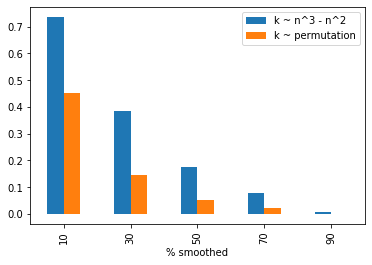

In [144]:
rand_info = experiment1(random_disconnect=False)

rand_stats = get_stats(rand_info)
rand_stats['k ~ permutation'] = 1-rand_stats['k ~ permutation']
rand_stats['k ~ n^3 - n^2'] = 1-rand_stats['k ~ n^3 - n^2']
names_df = rand_stats["Genre"].str.split(" ").apply(pd.Series)
xvar = "% smoothed"
names_df.columns=[xvar,"iteration"]
names_df
rand_stats = names_df.join(rand_stats).drop("Genre",axis=1)
rand_stats[xvar]=rand_stats[xvar].astype(int)

data = rand_stats.pivot_table(index=xvar,values=rand_stats.columns.drop([xvar,"iteration"]),aggfunc=np.mean).sort_values(by=xvar)

data.plot.bar()

10
30
50
70
90


,Genre,k,k ~ permutation,k ~ n^3 - n^2,# items,# 0 items
8,10 8,647,0.446207,0.170263,20,0
2,10 2,652,0.456903,0.171579,20,0
3,10 3,661,0.446924,0.173947,20,0
1,10 1,678,0.463115,0.178421,20,0
6,10 6,745,0.488845,0.196053,20,0
9,10 9,751,0.486399,0.197632,20,0
0,10 0,778,0.494596,0.204737,20,0
4,10 4,823,0.516960,0.216579,20,0
7,10 7,839,0.528005,0.220789,20,0
5,10 5,889,0.548427,0.233947,20,0


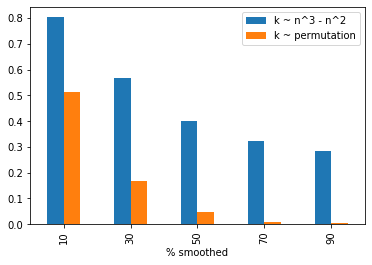

In [145]:
rand_info = experiment1(random_disconnect=True)

rand_stats = get_stats(rand_info)
rand_stats['k ~ permutation'] = 1-rand_stats['k ~ permutation']
rand_stats['k ~ n^3 - n^2'] = 1-rand_stats['k ~ n^3 - n^2']
names_df = rand_stats["Genre"].str.split(" ").apply(pd.Series)
xvar = "% smoothed"
names_df.columns=[xvar,"iteration"]
names_df
rand_stats = names_df.join(rand_stats).drop("Genre",axis=1)
rand_stats[xvar]=rand_stats[xvar].astype(int)

data = rand_stats.pivot_table(index=xvar,values=rand_stats.columns.drop([xvar,"iteration"]),aggfunc=np.mean).sort_values(by=xvar)

data.plot.bar()

In [49]:
DATA_DIR='ml-latest-small'
PROCESS=False

## Read and preprocess the data

In [50]:
links = pd.read_csv("%s/links.csv"%DATA_DIR)
display(links.head())
links["tmdbId"] = links["tmdbId"].fillna(-1).astype(int)
display(links.head())
display(links.dtypes)

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


,movieId,imdbId,tmdbId
0,1,114709,862
1,2,113497,8844
2,3,113228,15602
3,4,114885,31357
4,5,113041,11862


movieId    int64
imdbId     int64
tmdbId     int64
dtype: object

In [51]:
movies = pd.read_csv("%s/movies.csv"%DATA_DIR)
display(movies.head())
movies["genres"] = movies["genres"].str.split("|")
display(movies.head())

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


,movieId,title,genres
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]"
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]"
2,3,Grumpier Old Men (1995),"[Comedy, Romance]"
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]"
4,5,Father of the Bride Part II (1995),[Comedy]


In [52]:
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()

movies = movies.join(pd.DataFrame(mlb.fit_transform(movies['genres']),
                          columns=mlb.classes_,
                          index=movies.index))


In [53]:
movies

,movieId,title,genres,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",0,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]",0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),"[Comedy, Romance]",0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]",0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
4,5,Father of the Bride Part II (1995),[Comedy],0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),"[Action, Animation, Comedy, Fantasy]",0,1,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
9738,193583,No Game No Life: Zero (2017),"[Animation, Comedy, Fantasy]",0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
9739,193585,Flint (2017),[Drama],0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9740,193587,Bungo Stray Dogs: Dead Apple (2018),"[Action, Animation]",0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [54]:
ratings = pd.read_csv("%s/ratings.csv"%DATA_DIR)
ratings["movieId"] = ratings["movieId"].astype("category").cat.as_ordered()
display(ratings.head())
display(ratings.dtypes)

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


userId          int64
movieId      category
rating        float64
timestamp       int64
dtype: object

## Exploratory

**Number of unique movies along with their counts**

In [55]:
ratings.set_index("movieId").join(movies.set_index("movieId"))["title"].value_counts()

Forrest Gump (1994)                 329
Shawshank Redemption, The (1994)    317
Pulp Fiction (1994)                 307
Silence of the Lambs, The (1991)    279
Matrix, The (1999)                  278
                                   ... 
Northanger Abbey (2007)               1
Front Cover (2016)                    1
Dedication (2007)                     1
Collector, The (1965)                 1
Delta Force, The (1986)               1
Name: title, Length: 9719, dtype: int64

**What if we say 50 people in total had to rank a movie to even start considering it?**

In [56]:
counts = ratings.set_index("movieId").join(movies.set_index("movieId"))["title"].value_counts()
counts[counts > 50]

Forrest Gump (1994)                 329
Shawshank Redemption, The (1994)    317
Pulp Fiction (1994)                 307
Silence of the Lambs, The (1991)    279
Matrix, The (1999)                  278
                                   ... 
The Devil's Advocate (1997)          51
Army of Darkness (1993)              51
Bad Boys (1995)                      51
Mulholland Drive (2001)              51
Splash (1984)                        51
Name: title, Length: 437, dtype: int64

**This gets us to 437 movies, so that's a decent D matrix I think.**

For a start, let's fill in values in D by finding users who ranked two movies and then storing the difference in rating.

In [57]:
import joblib
import dask
import dask.dataframe as dd

if PROCESS == True:
    dask.config.set(temporary_directory='/dev/shm')

    ratings_dd = dd.from_pandas(ratings,npartitions=24)
    ratings_dd = ratings_dd.set_index("userId")

    from itertools import combinations
    flatten = lambda l: [item for sublist in l for item in sublist]

    def generic_apply_func(df):
        rdf = pd.DataFrame([flatten(tup) for tup in list(combinations(df.values,2))],
                           columns=[v+"_i"for v in df.columns]+[v+"_j"for v in df.columns],dtype=int)
        #rdf.set_index(["movieId_i","movieId_j"],inplace=True)
        rdf["difference"] = rdf["rating_i"] - rdf["rating_j"]
        rdf["pairs"] = 1
        rdf["score_if_won"] = (rdf["difference"] > 0)*rdf["difference"]
        rdf["score_if_lost"] = (rdf["difference"] < 0)*rdf["difference"]
        rdf["tied?"] = rdf["difference"] == 0
        #dtype = pd.SparseDtype(float, fill_value=0.0)
        #info_i_j = rdf.astype(dtype)
        return rdf

    def apply_func(gdf):
        info_i_j = generic_apply_func(gdf)
        info_i_j.reset_index(inplace=True)
        #data = info_i_j.groupby(["movieId_i","movieId_j"])[["difference","pairs","score_if_won","score_if_lost","tied?"]].apply(lambda x: x.sum()).reset_index()
        return info_i_j[['movieId_i', 'movieId_j', "difference","pairs","score_if_won","score_if_lost","tied?"]]
        ### !!!! need to aggregate here over the users so it doesn't get nuts later just need to figure out how to return it. consider just a single index and put things in the columns
        #table = info_i_j.pivot_table(index=["movieId_i"],columns=["movieId_j"],values="score_if_won",
                                                                  #aggfunc="sum")
        #ret = pd.DataFrame(index=ratings.movieId.cat.categories,columns=ratings.movieId.cat.categories)
        #ret.loc[table.index,table.columns] = table
    df1 = ratings_dd.groupby("userId").apply(apply_func,meta=pd.DataFrame(columns=['movieId_i', 'movieId_j', 'difference', 'pairs', 'score_if_won', 'score_if_lost', 'tied?']))
    #,).compute(scheduler='processes')

    #df1.groupby(["movieId_i","movieId_j"]).agg({'score_if_won': 'sum', 'score_if_lost': 'sum', 'tied?': 'sum', 'difference': 'count'})

    dtype = pd.SparseDtype(float, fill_value=0.0)

    def movieId_i_apply(x):
        x = x.astype(dtype)
        return x.groupby("movieId_j").apply(lambda x: x.sum())

    df1 = df1.groupby("movieId_i").apply(movieId_i_apply,meta=pd.DataFrame(columns=['movieId_i', 'movieId_j', 'difference', 'pairs', 'score_if_won', 'score_if_lost', 'tied?'])).compute(scheduler='processes')

    df1
    
    df2 = df1.drop(["movieId_i","movieId_j"],axis=1)
    
    joblib.dump({"df1":df1,"df2":df2},"movielens-preprocess.joblib.z")
else:
    loaded = joblib.load("movielens-preprocess.joblib.z")

    df1 = loaded['df1']
    df2 = loaded['df2']

In [58]:
df1.head()

movieId_i  movieId_j  difference  pairs  score_if_won  \
movieId_i movieId_j                                                          
78        79.0            78.0       79.0         1.0    1.0           1.0   
          81.0           156.0      162.0         1.0    2.0           1.0   
          86.0           156.0      172.0         0.0    2.0           0.0   
          88.0            78.0       88.0         1.0    1.0           1.0   
          89.0            78.0       89.0         0.0    1.0           0.0   

                     score_if_lost  tied?  
movieId_i movieId_j                        
78        79.0                 0.0    0.0  
          81.0                 0.0    1.0  
          86.0                 0.0    2.0  
          88.0                 0.0    0.0  
          89.0                 0.0    1.0

In [59]:
df2.describe()

,difference,pairs,score_if_won,score_if_lost,tied?
count,1.439635e+07,1.439635e+07,1.439635e+07,1.439635e+07,1.439635e+07
mean,5.138380e-02,2.111414e+00,1.064220e+00,-1.012836e+00,4.319360e-01
std,2.941246e+00,3.435164e+00,2.361889e+00,2.228711e+00,1.011910e+00
min,-1.445000e+02,1.000000e+00,0.000000e+00,-1.535000e+02,0.000000e+00
25%,-1.000000e+00,1.000000e+00,0.000000e+00,-1.000000e+00,0.000000e+00
50%,0.000000e+00,1.000000e+00,5.000000e-01,0.000000e+00,0.000000e+00
75%,1.000000e+00,2.000000e+00,1.500000e+00,0.000000e+00,1.000000e+00
max,1.525000e+02,2.190000e+02,1.605000e+02,0.000000e+00,1.200000e+02


In [60]:
df2.head()

difference  pairs  score_if_won  score_if_lost  tied?
movieId_i movieId_j                                                       
78        79.0              1.0    1.0           1.0            0.0    0.0
          81.0              1.0    2.0           1.0            0.0    1.0
          86.0              0.0    2.0           0.0            0.0    2.0
          88.0              1.0    1.0           1.0            0.0    0.0
          89.0              0.0    1.0           0.0            0.0    1.0

## Filter based on frequency

In [61]:
min_count = 20
min_mask = df2["pairs"] >= min_count
print(df2.shape[0],"to",min_mask.sum())
info_i_j = df2.loc[min_mask]

14396347 to 101086


In [62]:
info_i_j.dtypes

difference       float64
pairs            float64
score_if_won     float64
score_if_lost    float64
tied?            float64
dtype: object

In [63]:
dtype = pd.SparseDtype(float, fill_value=0.0)
info_i_j = info_i_j.astype(dtype)

In [64]:
info_i_j

difference  pairs  score_if_won  score_if_lost  tied?
movieId_i movieId_j                                                       
105       296.0           -16.0   20.0           3.5          -19.5    5.0
141       150.0           -14.5   38.0          11.0          -25.5   13.0
          153.0            24.5   37.0          29.5           -5.0    8.0
          160.0            17.0   20.0          18.0           -1.0    6.0
          161.0             5.5   26.0          14.0           -8.5    6.0
...                         ...    ...           ...            ...    ...
99114     122886.0         -2.0   25.0          10.5          -12.5    7.0
          122904.0          5.0   32.0          15.0          -10.0    9.0
          134130.0         -5.0   27.0           8.5          -13.5    3.0
          134853.0         -2.5   27.0          10.5          -13.0    7.0
          139385.0         -1.0   24.0           7.0           -8.0    6.0

[101086 rows x 5 columns]

In [65]:
ties_i_j = info_i_j["tied?"].unstack()
ties_i_j.columns = ties_i_j.columns.astype(int)
ties_i_j

movieId_j,296,150,153,160,161,165,185,186,208,223,...,45672,48738,80549,87306,88405,117529,7099,519,3072,3984
movieId_i,,,,,,,,,,,,,,,,,,,,,
105,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
141,12.0,13.0,8.0,6.0,6.0,11.0,11.0,5.0,9.0,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
193,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
337,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
431,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63082,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
77561,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
91542,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [66]:
wins_i_j = info_i_j["score_if_won"].unstack()
wins_i_j.columns = wins_i_j.columns.astype(int)
wins_i_j

movieId_j,296,150,153,160,161,165,185,186,208,223,...,45672,48738,80549,87306,88405,117529,7099,519,3072,3984
movieId_i,,,,,,,,,,,,,,,,,,,,,
105,3.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
141,12.5,11.0,29.5,18.0,14.0,19.0,18.5,18.0,23.5,6.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
193,1.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
337,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
431,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63082,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
77561,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
91542,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [67]:
counts_i_j = info_i_j["pairs"].unstack()
counts_i_j.columns = counts_i_j.columns.astype(int)
counts_i_j

movieId_j,296,150,153,160,161,165,185,186,208,223,...,45672,48738,80549,87306,88405,117529,7099,519,3072,3984
movieId_i,,,,,,,,,,,,,,,,,,,,,
105,20.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
141,49.0,38.0,37.0,20.0,26.0,33.0,30.0,22.0,30.0,25.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
193,25.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
337,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
431,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63082,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
77561,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
91542,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [68]:
loses_i_j = info_i_j["score_if_lost"].unstack()
loses_i_j.columns = loses_i_j.columns.astype(int)
loses_i_j

movieId_j,296,150,153,160,161,165,185,186,208,223,...,45672,48738,80549,87306,88405,117529,7099,519,3072,3984
movieId_i,,,,,,,,,,,,,,,,,,,,,
105,-19.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
141,-39.5,-25.5,-5.0,-1.0,-8.5,-8.0,-10.0,-5.0,-5.5,-22.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
193,-41.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
337,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
431,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63082,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
77561,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
91542,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Sparse format to D
We now have a sparse format, but we need to turn this into a D matrix. Let's only use a movie if there exists a paired count greater than 10.

In [69]:
counts_i_j_genres = counts_i_j.join(movies.set_index("movieId")).transpose().join(movies.set_index("movieId"))
wins_i_j_genres = wins_i_j.join(movies.set_index("movieId")).transpose().join(movies.set_index("movieId"))
loses_i_j_genres = loses_i_j.join(movies.set_index("movieId")).transpose().join(movies.set_index("movieId"))
ties_i_j_genres = ties_i_j.join(movies.set_index("movieId")).transpose().join(movies.set_index("movieId"))
counts_i_j_genres

,105,141,193,337,431,541,555,616,648,780,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
296,20,49,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
150,NaN,38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
153,NaN,37,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
160,NaN,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
161,NaN,26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Romance,1,0,0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Sci-Fi,0,0,0,0,0,1,0,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Thriller,0,0,0,0,0,1,1,0,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
War,0,0,0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [70]:
wins_i_j_genres.head()

,105,141,193,337,431,541,555,616,648,780,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
296,3.5,12.5,1.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
150,NaN,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
153,NaN,29.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
160,NaN,18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
161,NaN,14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0


In [71]:
loses_i_j_genres.head()

,105,141,193,337,431,541,555,616,648,780,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
296,-19.5,-39.5,-41.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
150,NaN,-25.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
153,NaN,-5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
160,NaN,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
161,NaN,-8.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0


In [72]:
from scipy.sparse import csr_matrix,lil_matrix
import networkx as nx
import matplotlib.pyplot as plt

genres = list(movies.columns[5:]) #["Comedy","Romance"]

genre_info = {}

for genre in genres:
    print(genre)

    j_inxs = np.where(counts_i_j_genres.loc[genre] == 1)[0]
    i_inxs = np.where(counts_i_j_genres.loc[:,genre] == 1)[0]

    wins_i_j_genre = wins_i_j_genres.iloc[i_inxs,:].iloc[:,j_inxs]
    loses_i_j_genre = loses_i_j_genres.iloc[i_inxs,:].iloc[:,j_inxs]
    ties_i_j_genre = ties_i_j_genres.iloc[i_inxs,:].iloc[:,j_inxs]
    counts_i_j_genre = counts_i_j_genres.iloc[i_inxs,:].iloc[:,j_inxs]

    items = list(set(counts_i_j_genre.columns).union(set(counts_i_j_genre.index)))
    
    if len(items) <= 5:
        print(genre,"is being excluded due to lack of items")
        continue
    
    items_hash = {}
    c = 0
    for item in items:
        items_hash[item] = c
        c+=1

    n = len(items)
    D = lil_matrix((n,n), dtype=float)
    # Process wins
    wins_i_j_genre_stacked = wins_i_j_genre.stack()
    for inx in wins_i_j_genre_stacked.index:
        i,j = inx
        D[items_hash[i],items_hash[j]] += wins_i_j_genre_stacked.loc[inx]
        
    # Process loses
    loses_i_j_genre_stacked = loses_i_j_genre.stack()
    for inx in loses_i_j_genre_stacked.index:
        i,j = inx
        D[items_hash[j],items_hash[i]] += -loses_i_j_genre_stacked.loc[inx]
            
    # Process ties
    ties_i_j_genre_stacked = ties_i_j_genre.stack()
    for inx in ties_i_j_genre_stacked.index:
        i,j = inx
        D[items_hash[i],items_hash[j]] += 0.5*ties_i_j_genre_stacked.loc[inx]
        D[items_hash[j],items_hash[i]] += 0.5*ties_i_j_genre_stacked.loc[inx]
        
    D = D.tocsr()
    print("Shape:",D.shape)
    
    genre_info[genre] = {}
    genre_info[genre]['D']  = D
    genre_info[genre]['items_hash'] = items_hash

Adventure
Shape: (301, 301)
Animation
Shape: (81, 81)
Children
Shape: (105, 105)
Comedy
Shape: (450, 450)
Crime
Shape: (187, 187)
Documentary
Documentary is being excluded due to lack of items
Drama
Shape: (454, 454)
Fantasy
Shape: (146, 146)
Film-Noir
Shape: (11, 11)
Horror
Shape: (79, 79)
IMAX
Shape: (54, 54)
Musical
Shape: (46, 46)
Mystery
Shape: (89, 89)
Romance
Shape: (211, 211)
Sci-Fi
Shape: (226, 226)
Thriller
Shape: (323, 323)
War
Shape: (53, 53)
Western
Shape: (24, 24)


In [73]:
for key in genre_info.keys():
    D = genre_info[key]['D']
    dg = nx.DiGraph()
    g = nx.Graph()

    for i in range(D.shape[0]):
        for j in range(D.shape[1]):
            if D[i,j] > 0:
                dg.add_weighted_edges_from([(i,j, D[i,j])])
                g.add_edge(i,j)
                
    dis_subgraphs = list(nx.connected_component_subgraphs(g))
    genre_info[key]['dg'] = dg
    genre_info[key]['g'] = g
    genre_info[key]['dis_subgraphs'] = dis_subgraphs
    #fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    #ax.set_title(genre)
    #nx.draw(dg, ax=ax)

### Find any rows with 0 entries and then set them aside for adding to the bottom

In [74]:
for key in genre_info.keys():
    D = genre_info[key]['D']
    empty_items = set(range(genre_info["Comedy"]['D'].shape[0])) - set(genre_info["Comedy"]['g'].nodes)
    genre_info[key]['empty_items'] = empty_items
    D = D[np.array(genre_info[key]['g'].nodes),:][:,np.array(genre_info[key]['g'].nodes)]
    print(genre_info[key]['D'].shape,D.shape)
    genre_info[key]['D_orig'] = genre_info[key]['D']
    genre_info[key]['D'] = D

(301, 301) (292, 292)
(81, 81) (78, 78)
(105, 105) (101, 101)
(450, 450) (437, 437)
(187, 187) (178, 178)
(454, 454) (443, 443)
(146, 146) (135, 135)
(11, 11) (7, 7)
(79, 79) (66, 66)
(54, 54) (49, 49)
(46, 46) (42, 42)
(89, 89) (82, 82)
(211, 211) (197, 197)
(226, 226) (217, 217)
(323, 323) (310, 310)
(53, 53) (52, 52)
(24, 24) (16, 16)


In [75]:
results_df = pd.DataFrame(columns=["Genre","# items","# 0 items"])
for key in genre_info.keys():
    row = pd.Series([key,genre_info[key]["D_orig"].shape[0],genre_info[key]["D_orig"].shape[0]-genre_info[key]["D"].shape[0]],index=results_df.columns)
    results_df = results_df.append(row,ignore_index=True)
results_df.head()

,Genre,# items,# 0 items
0,Adventure,301,9
1,Animation,81,3
2,Children,105,4
3,Comedy,450,13
4,Crime,187,9


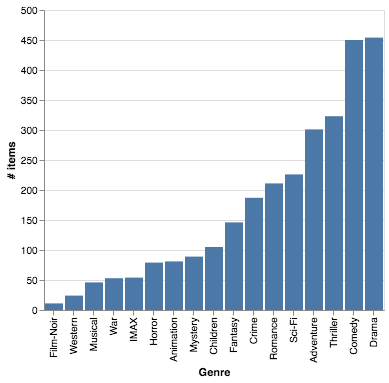

In [76]:
import altair as alt

alt.Chart(results_df).mark_bar().encode(y="# items",x=alt.X('Genre',
                                                            sort = alt.EncodingSortField(
                                                            field="# items",
                                                            order="ascending")))

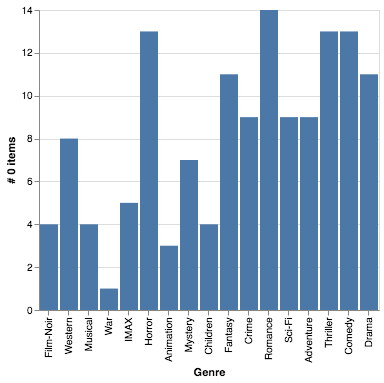

In [77]:
alt.Chart(results_df).mark_bar().encode(y="# 0 items",x=alt.X('Genre',
                                                            sort = alt.EncodingSortField(
                                                            field="# items",
                                                            order="ascending")))

In [91]:
genre_info["Western"]

{'D': <16x16 sparse matrix of type '<class 'numpy.float64'>'
 	with 70 stored elements in Compressed Sparse Row format>,
 'items_hash': {1408: 0,
  2951: 1,
  266: 2,
  2701: 3,
  1304: 4,
  82459: 5,
  163: 6,
  3624: 7,
  553: 8,
  99114: 9,
  2478: 10,
  303: 11,
  432: 12,
  1201: 13,
  590: 14,
  56782: 15,
  54997: 16,
  3671: 17,
  2012: 18,
  4321: 19,
  3681: 20,
  1378: 21,
  368: 22,
  1266: 23},
 'dg': <networkx.classes.digraph.DiGraph at 0x7f5abce3b400>,
 'g': <networkx.classes.graph.Graph at 0x7f5abce3bf98>,
 'dis_subgraphs': [<networkx.classes.graph.Graph at 0x7f5abce3b6d8>],
 'empty_items': {29, 43, 84, 92, 203, 246, 263, 273, 278, 284, 307, 308, 387},
 'D_orig': <24x24 sparse matrix of type '<class 'numpy.float64'>'
 	with 70 stored elements in Compressed Sparse Row format>,
 'k': 733,
 'details': {'P': [],
  'x': array([[1.00000000e+00, 5.24734682e-01, 1.00000000e+00, 1.00000000e+00,
          1.00000000e+00, 2.54438644e-01, 4.47182614e-01, 1.22689311e-12,
          2

In [ ]:
if True or PROCESS:
    for genre in ["Children","Western"]:#genre_info.keys():
        print(genre)
        D = genre_info[genre]['D'].todense()
        print("lp with constraints level 1")
        %timeit -n 1 -r 1 genre_info[genre]["k"],genre_info[genre]["details"] = pyrankability.hillside.count(D,relaxation_method='constraints',iterations=20,max_solutions=2)
        %timeit -n 1 -r 1 genre_info[genre]["k_lp"],genre_info[genre]["details_lp"] = pyrankability.hillside.count(D,relaxation_method='constraints',level=1)

Children
lp with constraints level 1
Iteration 1
Number of new solutions 1
Iteration 2
Number of new solutions 1
Iteration 3
Number of new solutions 1
Iteration 4
Number of new solutions 1
Iteration 5
Number of new solutions 1
Iteration 6
Number of new solutions 1
Iteration 7
Number of new solutions 1
Iteration 8
Number of new solutions 1
Iteration 9
Number of new solutions 1
Iteration 10
Number of new solutions 1
Iteration 11
Number of new solutions 1
Iteration 12
Number of new solutions 1
Iteration 13
Number of new solutions 1
Iteration 14
Number of new solutions 1
Iteration 15


In [81]:
output_dir="/home/ubuntu/rankabilitylib-data/ml-latest-small/D.v2"
k_df = pd.DataFrame(columns=["k"],index=["Children","Western"])
for genre in k_df.index:
    pd.DataFrame(genre_info[genre]["D"].todense()).to_csv("%s/%s.csv"%(output_dir,genre),index=False,header=False)
    movie_titles = movies.set_index("movieId").loc[genre_info[genre]['items_hash'].keys(),"title"].to_frame()
    movie_titles.reset_index().to_csv("%s/%s_movie_titles.csv"%(output_dir,genre),index=False)
    k_df.loc[genre,"k"] = genre_info[genre]["k"]
    pd.DataFrame(pyrankability.hillside.threshold_x(genre_info[genre]["details"]["x"])).to_csv("%s/%s_x.csv"%(output_dir,genre),index=False,header=False)    
    
k_df.to_csv("%s/k_data.csv"%output_dir,index=False)    

In [43]:
if False:
    for genre in ["Western"]:#genre_info.keys():
        print(genre)
        D = genre_info[genre]['D'].todense()
        print("count with constraints")
        %timeit -n 1 -r 1 genre_info[genre]["k_constraints"],genre_info[genre]["details_constraints"] = pyrankability.hillside.count(D,relaxation_method='constraints')
        #print("count with cut")
        #%timeit -n 1 -r 1 genre_info[genre]["k_cut"],genre_info[genre]["details_cut"] = pyrankability.hillside.count(D,relaxation_method='cut')
        
        #this does not return the correct result
        #print("lp with cut")
        #%timeit -n 1 -r 1 genre_info[genre]["k_lp_cut"],genre_info[genre]["details_lp_cut"] = pyrankability.hillside.count_lp(D,relaxation_method='cut')
        
        print("lp no relaxation")
        %timeit -n 1 -r 1 genre_info[genre]["k_lp_no_relax"],genre_info[genre]["details_lp_no_relax"] = pyrankability.hillside.count_lp(D,relaxation_method='')
        print("lp with constraints level 1")
        %timeit -n 1 -r 1 genre_info[genre]["k_lp_constraints_level_1"],genre_info[genre]["details_lp_constraints_level_1"] = pyrankability.hillside.count_lp(D,relaxation_method='constraints',level=1)
        print("lp with constraints level 2")
        %timeit -n 1 -r 1 genre_info[genre]["k_lp_constraints_level_2"],genre_info[genre]["details_lp_constraints_level_2"] = pyrankability.hillside.count_lp(D,relaxation_method='constraints',level=2)

        display(pd.Series(genre_info[genre]).loc[["details_lp_constraints_level_1","details_lp_constraints_level_2"]])
    joblib.dump({"genre_info":genre_info},"verify_xstar-1.joblib.z")
else:
    loaded2 = joblib.load("verify_xstar-1.joblib.z")

    genre_info = loaded2['genre_info']

Western
count with constraints
Iteration 1
114 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
lp no relaxation
91.7 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
lp with constraints level 1
97.4 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
lp with constraints level 2
95.8 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


details_lp_constraints_level_1    {'P': [], 'x': [[1.0, 0.5247346819676049, 0.99...
details_lp_constraints_level_2    {'P': [], 'x': [[1.0, 0.5247346819676049, 0.99...
dtype: object

In [44]:
(pyrankability.hillside.threshold_x(genre_info[genre]["details_lp_no_relax"]["x"])!=pyrankability.hillside.threshold_x(genre_info[genre]["details_lp_constraints_level_2"]["x"])).sum()

0